# Логистическая регрессия
## 0) Загрузка пакетов и данных
Эта модель поможет определить знаки коэффициентов при объясняющих переменных

In [71]:
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, auc 
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import SGDClassifier # стохастический градиентный спуск
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
raw = pd.read_csv('curry1415.csv', header=0)

## 1) Feature engineering

In [3]:
# Интересно, есть ли разница для алгоритма между переменными "координаты" и "расстояние" + "угол"?

# добавим более точную переменную расстояния
raw['dist'] = np.sqrt(raw['x']**2 + raw['y']**2)

# введем угол броска

loc_x_zero = raw['x'] == 0
raw['angle'] = np.array([0]*len(raw))
raw['angle'][~loc_x_zero] = np.arctan(raw['y'][~loc_x_zero] / raw['x'][~loc_x_zero])
raw['angle'][loc_x_zero] = np.pi / 2 
raw2=raw.copy()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
# единая переменная оставшегося времени
raw['remaining_time'] = raw['minutes_remaining'] * 60 + raw['seconds_remaining']

# дропаем ненужные переменные
todrop = ['name', 'team_name', 'game_date', 'season', 'espn_player_id', 'team_id', \
          'espn_game_id', 'minutes_remaining', 'seconds_remaining', 'shot_distance', 'x', 'y', 'defender_name']

for i in todrop:
    raw = raw.drop(i, 1)
    
# создаем дамми-переменные из категориальных
categorical_vars = ['action_type', 'shot_type', 'opponent', 'period']

for i in categorical_vars:
    raw = pd.concat([raw, pd.get_dummies(raw[i], prefix=i)], 1)
    raw = raw.drop(i, 1)
    
# делим выборку на объясняющие переменные и таргетируемую
train = raw.drop('shot_made_flag', 1)
train_y = raw['shot_made_flag']

Создадим вторую объясняющую выборку с новыми переменными

In [5]:
# отсортируем по времени
sorted_raw = raw2.sort_values(['espn_game_id', 'period', 'minutes_remaining', 'seconds_remaining'], ascending=[1, 1, 0, 0])
sorted_raw.index=range(len(sorted_raw))

sorted_raw['previous1'] = np.zeros(len(sorted_raw)) 

for i,row in enumerate(sorted_raw[1:].iterrows()):
    if i>0:
        if sorted_raw.loc[i,'espn_game_id'] == sorted_raw.loc[i-1,'espn_game_id']:
            sorted_raw.loc[i,'previous1'] = sorted_raw.loc[i-1,'shot_made_flag']
            
sorted_raw['previous2'] = np.zeros(len(sorted_raw)) 

for i,row in enumerate(sorted_raw[1:].iterrows()):
    if i>1:
        if sorted_raw.loc[i,'espn_game_id'] == sorted_raw.loc[i-1,'espn_game_id'] == sorted_raw.loc[i-2,'espn_game_id']:
            if sorted_raw.loc[i-1,'shot_made_flag']==sorted_raw.loc[i-2,'shot_made_flag']==1:
                sorted_raw.loc[i,'previous2'] = raw.loc[i-1,'shot_made_flag']
                
sorted_raw['previous3'] = np.zeros(len(sorted_raw)) 

for i,row in enumerate(sorted_raw[1:].iterrows()):
    if i>2:
        if sorted_raw.loc[i,'espn_game_id'] == sorted_raw.loc[i-1,'espn_game_id'] == sorted_raw.loc[i-2,'espn_game_id']== sorted_raw.loc[i-3,'espn_game_id']:
            if sorted_raw.loc[i-1,'previous2']==sorted_raw.loc[i,'previous1']==1:
                sorted_raw.loc[i,'previous3'] = raw.loc[i-1,'shot_made_flag']
                
sorted_raw['previous1']=sorted_raw['previous1'].astype(int)
sorted_raw['previous2']=sorted_raw['previous2'].astype(int)
sorted_raw['previous3']=sorted_raw['previous3'].astype(int)

In [6]:
sorted_raw['remaining_time'] = sorted_raw['minutes_remaining'] * 60 + sorted_raw['seconds_remaining']
# дропаем ненужные переменные
todrop = ['name', 'team_name', 'game_date', 'season', 'espn_player_id', 'team_id', \
          'espn_game_id', 'minutes_remaining', 'seconds_remaining', 'shot_distance', 'x', 'y', 'defender_name']

for i in todrop:
    sorted_raw = sorted_raw.drop(i, 1)

# создаем дамми-переменные из категориальных
categorical_vars = ['action_type', 'shot_type', 'opponent', 'period']
# categorical_vars = ['action_type', 'shot_type', 'opponent', 'period', 'previous1', 'previous2', 'previous3']
for i in categorical_vars:
    sorted_raw = pd.concat([sorted_raw, pd.get_dummies(sorted_raw[i], prefix=i)], 1)
    sorted_raw = sorted_raw.drop(i, 1)
# делим выборку на объясняющие переменные и таргетируемую
train2 = sorted_raw.drop('shot_made_flag', 1)
train2_y = sorted_raw['shot_made_flag']

In [119]:
sorted_raw.to_csv('forR.csv', sep=',', index=False)

## 2) Логистическая регрессия
### Без включения предыдущих бросков

In [7]:
# создаем объект
lr=LogisticRegression(penalty='l2')

# рандомно делим выборку на 70/30
X_train, X_test, y_train, y_test = train_test_split(train, train_y, test_size=0.3, random_state=43)

# фитим модель
lr.fit(X_train, y_train)
pred1 = lr.predict(X_test)

In [8]:
# Таблица коэффициентов
coef=lr.coef_
cols = train.columns.values
coef_df = pd.DataFrame( {'Variables': cols,
     'Coefficients': coef[0],
    })

** В sklearn не реализован significance test**

Придется:

1. Либо найти скрипт реализации p-values

2. Либо прогнать логистическую регрессию через R (просто сохранить данные с в csv)

In [9]:
print('Accuracy:', accuracy_score(y_test, pred1))

Accuracy: 0.59925093633


**Оценки качества работы классификатора**

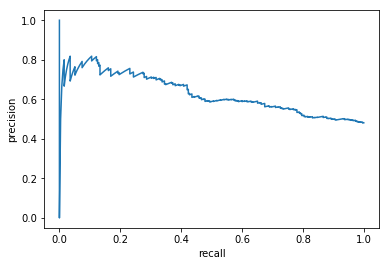

In [10]:
precision, recall, thresholds = precision_recall_curve(y_test, lr.predict_proba(X_test)[:, 1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [11]:
auc(recall, precision)

0.62566089083922072

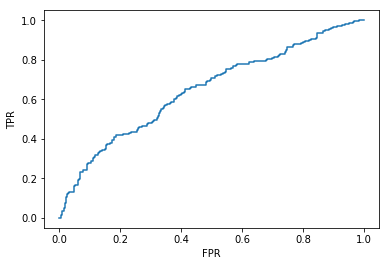

In [12]:
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [13]:
auc(fpr, tpr)

0.64788811581980466

### Включаем дополнительные переменные

In [66]:
# рандомно делим выборку на 70/30
X_train, X_test, y_train, y_test = train_test_split(train2, train2_y, test_size=0.15, random_state=88)

# фитим модель
lr.fit(X_train, y_train)
pred2 = lr.predict(X_test)

In [67]:
# Таблица коэффициентов
coef2=lr.coef_
cols2 = train2.columns.values
coef_df2 = pd.DataFrame( {'Variables': cols2,
     'Coefficients': coef2[0],
    })

In [110]:
coef_df2.head(10)

,Coefficients,Variables
0,0.073735,dribbles
1,-0.110726,touch_time
2,0.064691,defender_distance
3,0.010262,shot_clock
4,-0.002813,dist
5,0.019583,angle
6,-0.223405,previous1
7,-0.097678,previous2
8,0.159022,previous3
9,0.000355,remaining_time


In [68]:
print('Accuracy:', accuracy_score(y_test, pred2))

Accuracy: 0.610486891386


In [69]:
precision, recall, thresholds = precision_recall_curve(y_test, lr.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
print(auc(recall, precision),auc(fpr, tpr))

0.61182063161 0.657774997156


**Результаты:**

1. Точность увеличивается незначительно после включения дополнительных переменных
2. Коэффициенты при "забил 1 и 2 предыдущих" отрицательны. "Забил 3" -- положительный
3. Значимы ли эти коэффициенты?
4. Какие предельные эффекты?

## 2.1) Стохастический градиентный спуск
Попробуем бездумно применить этот метод для логистической модели

In [82]:
lr_sgd = SGDClassifier(loss="log", alpha=1, n_iter=200, fit_intercept=True, random_state=43)
lr_sgd.fit(X_train, y_train)
preds_sgd = lr_sgd.predict(X_test)
print('Accuracy:', accuracy_score(y_test, preds_sgd))

Accuracy: 0.588014981273


## 3) Валидация логистической регрессии

### 3.1) Shuffle Split
Делим выборку на *k* частей и усредняем результаты AUC PRC, AUC ROC

In [92]:
sp = ShuffleSplit(n_splits=10, test_size=0.30, random_state=88)
aucroc = []
aucprc = []
lr = LogisticRegression()
for train_index, test_index in sp.split(train):
    lr.fit(train.iloc[train_index], train_y.iloc[train_index])
    aucroc.append(roc_auc_score(train_y.iloc[test_index], lr.predict_proba(train.iloc[test_index])[:,1]))
    precision, recall, thresholds = precision_recall_curve(train_y.iloc[test_index], lr.predict_proba(train.iloc[test_index])[:, 1])
    aucprc.append(auc(recall, precision))

In [93]:
# Результаты увеличиваются незначительно
print(np.mean(aucprc), np.mean(aucroc))

0.660151108179 0.672714817266


### 3.2) Стратификация
Разбиваем выборку на обучение и тест с сохранением доли реализации различных типов бросков

In [94]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.30, random_state=88)
aucroc = []
aucprc = []
lr = LogisticRegression()
for train_index, test_index in sss.split(train, train_y):
    lr.fit(train.iloc[train_index], train_y.iloc[train_index])
    aucroc.append(roc_auc_score(train_y.iloc[test_index], lr.predict_proba(train.iloc[test_index])[:,1]))
    precision, recall, thresholds = precision_recall_curve(train_y.iloc[test_index], lr.predict_proba(train.iloc[test_index])[:, 1])
    aucprc.append(auc(recall, precision))

In [95]:
print(np.mean(aucprc), np.mean(aucroc))

0.637206925091 0.659637758543


### 3.3) K-fold кросс-валидация

In [106]:
kf = KFold(n_splits=10, shuffle=True, random_state=88)
aucroc = []
aucprc = []
lr = LogisticRegression()
for train_index, test_index in kf.split(train):
    lr.fit(train.iloc[train_index], train_y.iloc[train_index])
    aucroc.append(roc_auc_score(train_y.iloc[test_index], lr.predict_proba(train.iloc[test_index])[:,1]))
    precision, recall, thresholds = precision_recall_curve(train_y.iloc[test_index], lr.predict_proba(train.iloc[test_index])[:, 1])
    aucprc.append(auc(recall, precision))

In [107]:
print(np.mean(aucprc), np.mean(aucroc))

0.657124043695 0.678212939222
